# Attempting to extract params from multi-layered samples

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)

from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor

[((3.46+0.01j), 0.0005), ((2.5+0.015j), 0.00025)]


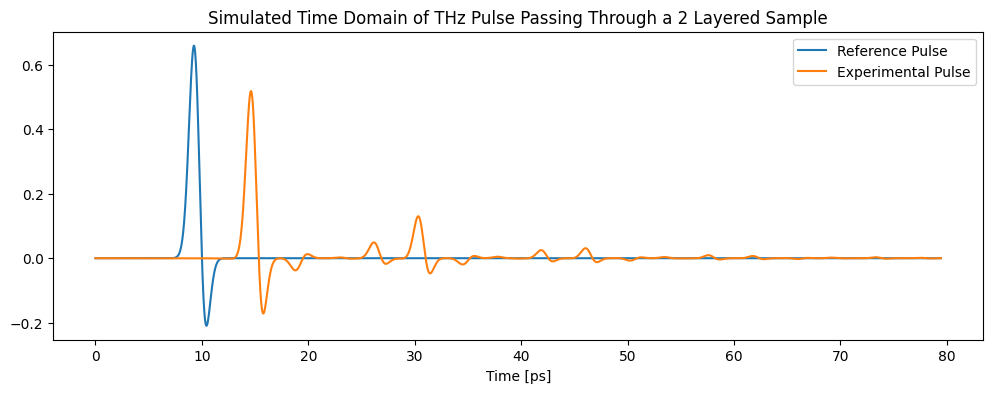

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 0.5e-3
n2, k2, d2= 2.5, 0.015, 0.25e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.title('Simulated Time Domain of THz Pulse Passing Through a 2 Layered Sample')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

## Test General model to fit all 3 parameters

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.34, 3.54)
Layer 1 - k ∈ (0.004999999999999999, 0.025)
Layer 2 - n ∈ (2.35, 2.5500000000000003)
Layer 2 - k ∈ (0.007000000000000001, 0.027000000000000003)
[((3.455846327007913+0.004999999999999999j), 0.0005), ((2.5095531251230576+0.027000000000000003j), 0.00025)]


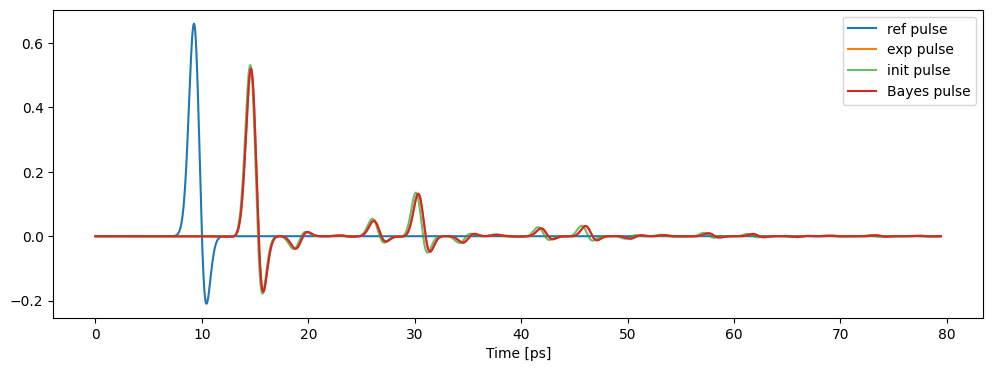

In [3]:
## Experimental params:
#n1, k1, d1 = 3.46, 0.01, 0.5e-3
#n2, k2, d2= 2.5, 0.015, 0.25e-3


layers_init = [(3.44+1j*0.015, 0.5e-3), (2.45+1j*0.017, 0.25e-3)]


optimization_mask = [
    (True, True, False),
    (True, True, False)
]

initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, optimize_mask=optimization_mask)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=60)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, initial_pulse, label='init pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

In [4]:
# TODO: show residuals between (init, true) and (bayes, true)

Fine-tuning 4 parameters for 100 iterations.
Iteration 4, Loss: 1.944622e-03, Layer 0: n=3.4587, k=0.01192, D=500.00 µm | Layer 1: n=2.5084, k=0.02958, D=250.00 µm
Iteration 9, Loss: 1.549283e-03, Layer 0: n=3.4605, k=0.00273, D=500.00 µm | Layer 1: n=2.5069, k=0.01803, D=250.00 µm
Iteration 14, Loss: 6.332377e-04, Layer 0: n=3.4597, k=0.00735, D=500.00 µm | Layer 1: n=2.5032, k=0.01988, D=250.00 µm
Iteration 19, Loss: 4.553115e-04, Layer 0: n=3.4604, k=0.00881, D=500.00 µm | Layer 1: n=2.5010, k=0.01771, D=250.00 µm
Iteration 24, Loss: 8.019640e-04, Layer 0: n=3.4631, k=0.01152, D=500.00 µm | Layer 1: n=2.5019, k=0.01679, D=250.00 µm
Iteration 29, Loss: 6.765365e-04, Layer 0: n=3.4607, k=0.00981, D=500.00 µm | Layer 1: n=2.4990, k=0.01303, D=250.00 µm
Iteration 34, Loss: 2.497677e-04, Layer 0: n=3.4607, k=0.00947, D=500.00 µm | Layer 1: n=2.4993, k=0.01201, D=250.00 µm
Iteration 39, Loss: 5.484129e-05, Layer 0: n=3.4605, k=0.00897, D=500.00 µm | Layer 1: n=2.4998, k=0.01208, D=250.00 

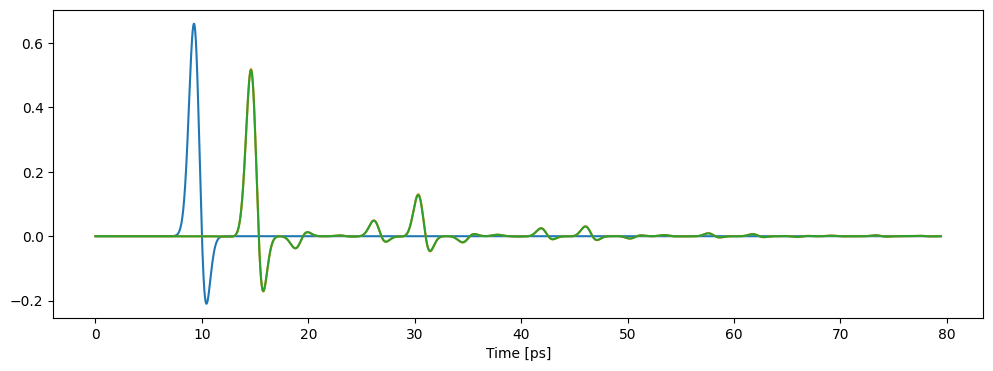

In [5]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.01, optimize_mask=optimization_mask)
optim_params = LE.optimize(num_iterations=100, updates=5 , alpha=1)



_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='opt pulse')
plt.xlabel('Time [ps]')
plt.show()

In [6]:
LE.best_loss

4.906320100417361e-05

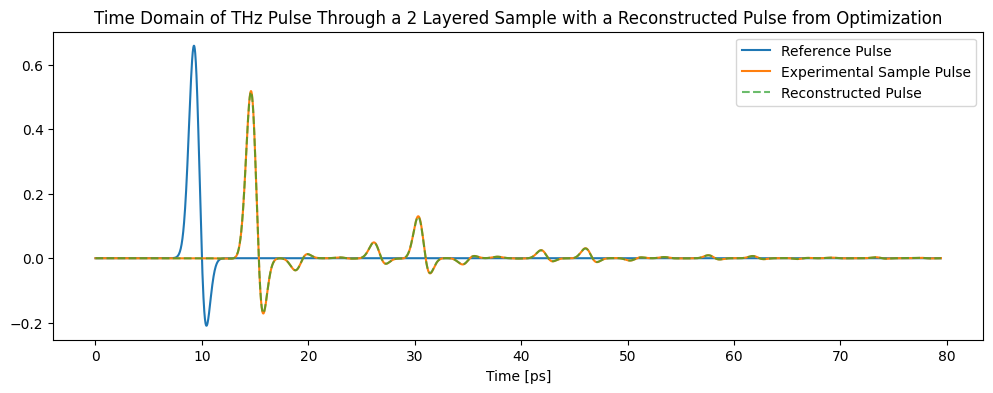

In [7]:
plt.figure(figsize=(12,4))
plt.title('Time Domain of THz Pulse Through a 2 Layered Sample with a Reconstructed Pulse from Optimization')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Sample Pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='Reconstructed Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

In [8]:
n1, k1 = f'{(100*(3.46 - 3.4592278003692627)/3.46):.4}%', f'{(100*(0.01 - 0.008798369206488132)/0.01):.4}%'
n2, k2 = f'{(100*(2.5 - 2.499274492263794)/2.5):.4}%', f'{(100*(0.015 - 0.013772462494671345)/0.015):.4}%'


print(f'$n_1: {n1}, k_1: {k1}, n_2: {n2}, k_2: {k2}$')

$n_1: 0.02232%, k_1: 12.02%, n_2: 0.02902%, k_2: 8.184%$


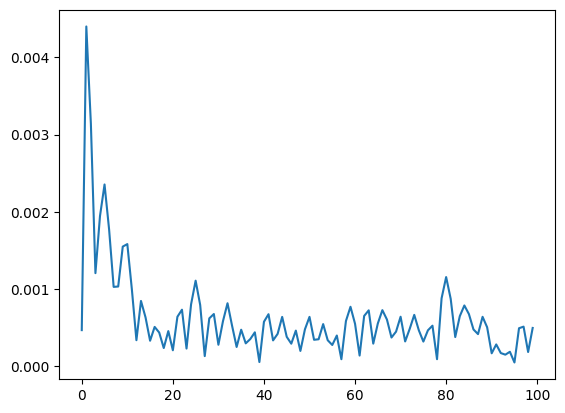

In [9]:
plt.plot(LE.loss_history)